In [91]:
# importando bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [92]:
# carregando base de dados
EFPg = np.load("DataEFPsJetTagging/EFP d5-connected-not_normalized/g_efps_d5_primed.npy")
EFPq = np.load("DataEFPsJetTagging/EFP d5-connected-not_normalized/q_efps_d5_primed.npy")
EFPt = np.load("DataEFPsJetTagging/EFP d5-connected-not_normalized/t_efps_d5_primed.npy")

# Preprocessing data

## Visualization

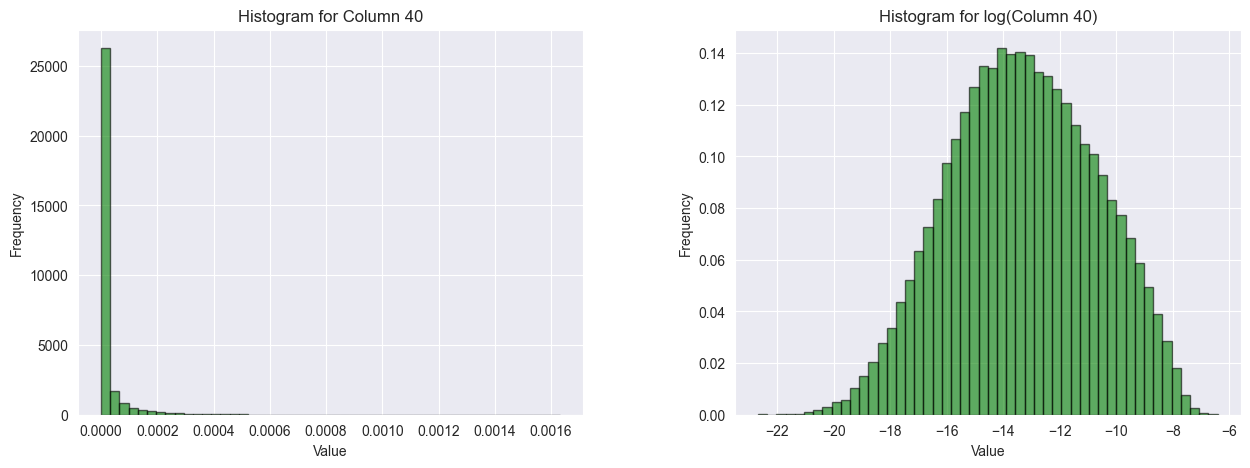

In [93]:
column_index = 40 # índice da coluna
data = EFPg[:, column_index] # valores da coluna
data_log = np.log(data) # logarithmic-scaling

nbins = 50 # número de bins no histograma

fig, axes = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1]})
fig.subplots_adjust(wspace=0.3)

# histograma - sem normalizar
axes[0].hist(data, bins=nbins, density=True, alpha=0.6, color='g', edgecolor='black')
axes[0].set_ylabel("Frequency")
axes[0].set_xlabel("Value")
axes[0].set_title(f'Histogram for Column {column_index}')

# histograma - normalizando
axes[1].hist(data_log, bins=nbins, density=True, alpha=0.6, color='g', edgecolor='black')
axes[1].set_ylabel("Frequency")
axes[1].set_xlabel("Value")
axes[1].set_title(f'Histogram for log(Column {column_index})')

plt.show()

## Normalization

In [94]:
# logarithmic-scaling (almost the same/worse)
scaledEFPg = np.log(EFPg)
scaledEFPq = np.log(EFPq)
scaledEFPt = np.log(EFPt)

In [95]:
# standard scaling
scalerg = StandardScaler()
scalerq = StandardScaler()
scalert = StandardScaler()

scalerg.fit(scaledEFPg)
scalerq.fit(scaledEFPq)
scalert.fit(scaledEFPt)

rescaledEFPg = scalerg.transform(scaledEFPg)
rescaledEFPq = scalerq.transform(scaledEFPq)
rescaledEFPt = scalert.transform(scaledEFPt)

# Top tagging

## Not normalizing

In [96]:
# separação de variáveis preditoras (features) e alvo (target)
X_g,y_g = EFPg, np.zeros((EFPg.shape[0], 1))
X_q,y_q = EFPq, np.zeros((EFPq.shape[0], 1))
X_t,y_t = EFPt, np.ones((EFPt.shape[0], 1))

# particionamento (amostragem estratificada)
X_g_train, X_g_test, y_g_train, y_g_test = train_test_split(X_g, y_g, test_size=0.2, random_state=1)
X_q_train, X_q_test, y_q_train, y_q_test = train_test_split(X_q, y_q, test_size=0.2, random_state=1)
X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(X_t, y_t, test_size=0.2, random_state=1)

X_train, X_test, y_train, y_test = (
    np.concatenate((X_g_train, X_q_train, X_t_train), axis=0),
    np.concatenate((X_g_test, X_q_test, X_t_test), axis=0),
    np.concatenate((y_g_train, y_q_train, y_t_train), axis=0),
    np.concatenate((y_g_test, y_q_test, y_t_test), axis=0)
)

### LinearDiscriminantAnalysis

Intercept: -5.370116258569907


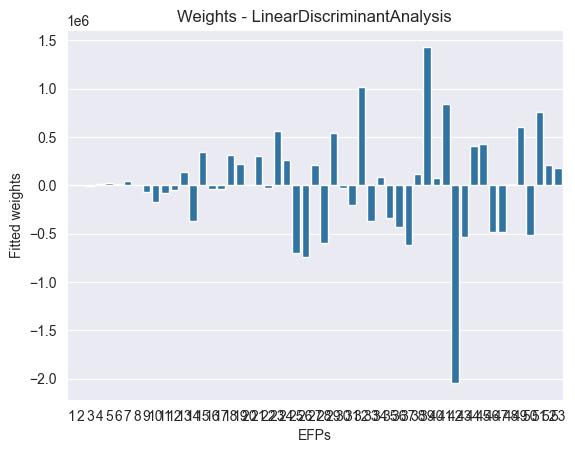

In [97]:
model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train.ravel())

# Intercept
print('Intercept:', model.intercept_[0])

# Weights
coef = model.coef_[0]
fig = sns.barplot (x=np.arange(1, len(coef)+1), y=coef)
plt.xlabel("EFPs")
plt.ylabel("Fitted weights")
plt.title("Weights - LinearDiscriminantAnalysis");

Classification Report - training set:
               precision    recall  f1-score   support

         0.0       0.91      0.92      0.91    278344
         1.0       0.84      0.82      0.83    142356

    accuracy                           0.89    420700
   macro avg       0.87      0.87      0.87    420700
weighted avg       0.89      0.89      0.89    420700

Confusion Matrix - training set:
 [[0.61 0.05]
 [0.06 0.28]]


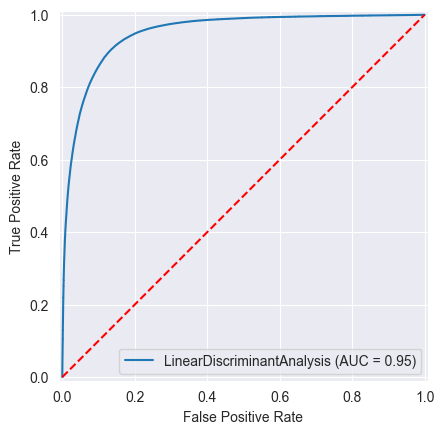

In [98]:
y_pred_train = model.predict(X_train)
# Classification Report - train
print('Classification Report - training set:\n',metrics.classification_report(y_train.ravel(), y_pred_train))

# Confusion Matrix - train
print('Confusion Matrix - training set:\n',metrics.confusion_matrix(y_train.ravel(), y_pred_train, normalize='all').round(2))

y_predproba_train = model.predict_proba(X_train)[:, -1]
# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_train.ravel(), y_predproba_train)
roc_auc = metrics.roc_auc_score(y_train.ravel(), y_predproba_train)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='LinearDiscriminantAnalysis')
display.plot()
plt.plot([0,1],[0,1],'r--')
plt.show()

Classification Report - test set:
               precision    recall  f1-score   support

         0.0       0.91      0.92      0.91     69587
         1.0       0.84      0.82      0.83     35589

    accuracy                           0.89    105176
   macro avg       0.87      0.87      0.87    105176
weighted avg       0.88      0.89      0.88    105176

Confusion Matrix - test set:
 [[0.61 0.05]
 [0.06 0.28]]


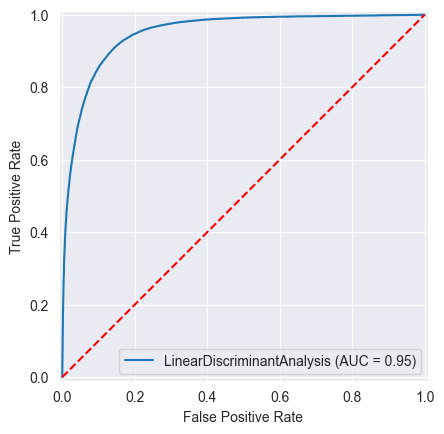

In [99]:
y_pred_test = model.predict(X_test)
# Classification Report - test
print('Classification Report - test set:\n',metrics.classification_report(y_test.ravel(), y_pred_test))

# Confusion Matrix - test
print('Confusion Matrix - test set:\n',metrics.confusion_matrix(y_test.ravel(), y_pred_test, normalize='all').round(2))

y_predproba_test = model.predict_proba(X_test)[:, -1]
# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test.ravel(), y_predproba_test)
roc_auc = metrics.roc_auc_score(y_test.ravel(), y_predproba_test)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='LinearDiscriminantAnalysis')
display.plot()
plt.plot([0,1],[0,1],'r--')
plt.show()

### QuadraticDiscriminantAnalysis

In [100]:
model = QuadraticDiscriminantAnalysis(tol=1.0e-6)
model.fit(X_train, y_train.ravel())

QuadraticDiscriminantAnalysis(tol=1e-06)

Classification Report - training set:
               precision    recall  f1-score   support

         0.0       0.85      0.94      0.89    278344
         1.0       0.85      0.68      0.75    142356

    accuracy                           0.85    420700
   macro avg       0.85      0.81      0.82    420700
weighted avg       0.85      0.85      0.85    420700

Confusion Matrix - training set:
 [[0.62 0.04]
 [0.11 0.23]]


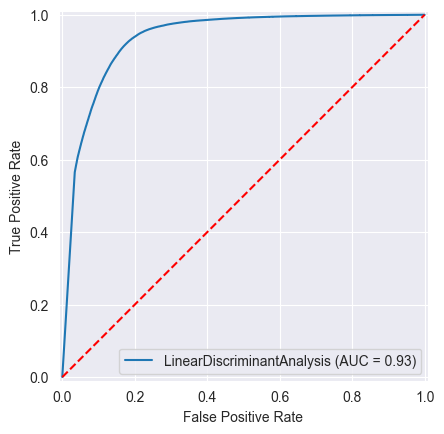

In [101]:
y_pred_train = model.predict(X_train)
# Classification Report - train
print('Classification Report - training set:\n',metrics.classification_report(y_train.ravel(), y_pred_train))

# Confusion Matrix - train
print('Confusion Matrix - training set:\n',metrics.confusion_matrix(y_train.ravel(), y_pred_train, normalize='all').round(2))

y_predproba_train = model.predict_proba(X_train)[:, -1]
# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_train.ravel(), y_predproba_train)
roc_auc = metrics.roc_auc_score(y_train.ravel(), y_predproba_train)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='LinearDiscriminantAnalysis')
display.plot()
plt.plot([0,1],[0,1],'r--')
plt.show()

Classification Report - test set:
               precision    recall  f1-score   support

         0.0       0.85      0.94      0.89     69587
         1.0       0.85      0.67      0.75     35589

    accuracy                           0.85    105176
   macro avg       0.85      0.80      0.82    105176
weighted avg       0.85      0.85      0.84    105176

Confusion Matrix - test set:
 [[0.62 0.04]
 [0.11 0.23]]


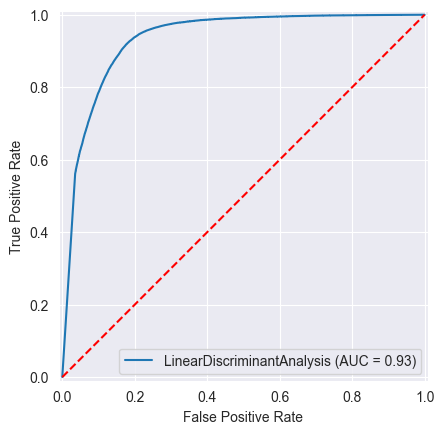

In [102]:
y_pred_test = model.predict(X_test)
# Classification Report - test
print('Classification Report - test set:\n',metrics.classification_report(y_test.ravel(), y_pred_test))

# Confusion Matrix - test
print('Confusion Matrix - test set:\n',metrics.confusion_matrix(y_test.ravel(), y_pred_test, normalize='all').round(2))

y_predproba_test = model.predict_proba(X_test)[:, -1]
# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test.ravel(), y_predproba_test)
roc_auc = metrics.roc_auc_score(y_test.ravel(), y_predproba_test)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='LinearDiscriminantAnalysis')
display.plot()
plt.plot([0,1],[0,1],'r--')
plt.show()

## Normalizing

In [103]:
# separação de variáveis preditoras (features) e alvo (target)
X_g,y_g = rescaledEFPg, np.zeros((rescaledEFPg.shape[0], 1))
X_q,y_q = rescaledEFPq, np.zeros((rescaledEFPq.shape[0], 1))
X_t,y_t = rescaledEFPt, np.ones((rescaledEFPt.shape[0], 1))

# particionamento (amostragem estratificada)
X_g_train, X_g_test, y_g_train, y_g_test = train_test_split(X_g, y_g, test_size=0.2, random_state=1)
X_q_train, X_q_test, y_q_train, y_q_test = train_test_split(X_q, y_q, test_size=0.2, random_state=1)
X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(X_t, y_t, test_size=0.2, random_state=1)

X_train, X_test, y_train, y_test = (
    np.concatenate((X_g_train, X_q_train, X_t_train), axis=0), np.concatenate((X_g_test, X_q_test, X_t_test), axis=0), np.concatenate((y_g_train, y_q_train, y_t_train), axis=0), np.concatenate((y_g_test, y_q_test, y_t_test), axis=0))

### LinearDiscriminantAnalysis

Intercept: -0.670546951308977


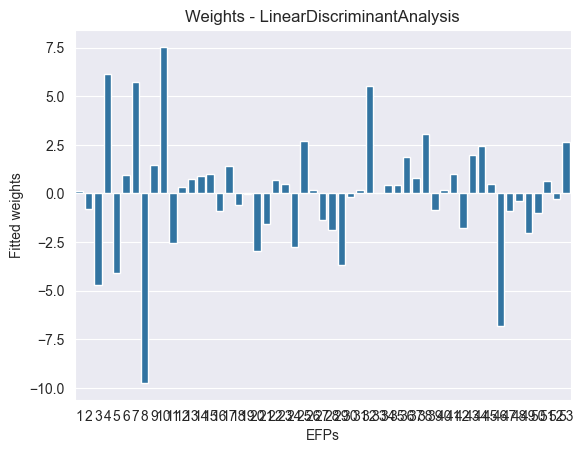

In [104]:
model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train.ravel())

# Intercept
print('Intercept:', model.intercept_[0])

# Weights
coef = model.coef_[0]
fig = sns.barplot (x=np.arange(1, len(coef)+1), y=coef)
plt.xlabel("EFPs")
plt.ylabel("Fitted weights")
plt.title("Weights - LinearDiscriminantAnalysis");

C:\Users\bruno\OneDrive\IA na física\projeto2 - classificação de jatos\pythonProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bruno\OneDrive\IA na física\projeto2 - classificação de jatos\pythonProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bruno\OneDrive\IA na física\projeto2 - classificação de jatos\pythonProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

Classification Report - training set:
               precision    recall  f1-score   support

         0.0       0.66      1.00      0.80    278344
         1.0       0.00      0.00      0.00    142356

    accuracy                           0.66    420700
   macro avg       0.33      0.50      0.40    420700
weighted avg       0.44      0.66      0.53    420700

Confusion Matrix - training set:
 [[0.66 0.  ]
 [0.34 0.  ]]


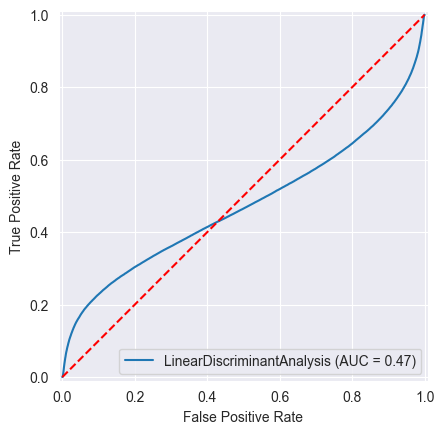

In [105]:
y_pred_train = model.predict(X_train)
# Classification Report - train
print('Classification Report - training set:\n',metrics.classification_report(y_train.ravel(), y_pred_train))

# Confusion Matrix - train
print('Confusion Matrix - training set:\n',metrics.confusion_matrix(y_train.ravel(), y_pred_train, normalize='all').round(2))

y_predproba_train = model.predict_proba(X_train)[:, -1]
# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_train.ravel(), y_predproba_train)
roc_auc = metrics.roc_auc_score(y_train.ravel(), y_predproba_train)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='LinearDiscriminantAnalysis')
display.plot()
plt.plot([0,1],[0,1],'r--')
plt.show()

C:\Users\bruno\OneDrive\IA na física\projeto2 - classificação de jatos\pythonProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bruno\OneDrive\IA na física\projeto2 - classificação de jatos\pythonProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bruno\OneDrive\IA na física\projeto2 - classificação de jatos\pythonProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

Classification Report - test set:
               precision    recall  f1-score   support

         0.0       0.66      1.00      0.80     69587
         1.0       0.00      0.00      0.00     35589

    accuracy                           0.66    105176
   macro avg       0.33      0.50      0.40    105176
weighted avg       0.44      0.66      0.53    105176

Confusion Matrix - test set:
 [[0.66 0.  ]
 [0.34 0.  ]]


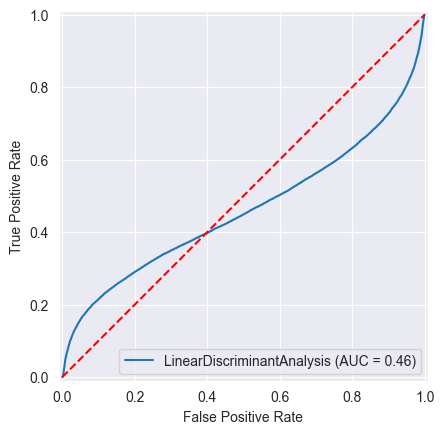

In [106]:
y_pred_test = model.predict(X_test)
# Classification Report - test
print('Classification Report - test set:\n',metrics.classification_report(y_test.ravel(), y_pred_test))

# Confusion Matrix - test
print('Confusion Matrix - test set:\n',metrics.confusion_matrix(y_test.ravel(), y_pred_test, normalize='all').round(2))

y_predproba_test = model.predict_proba(X_test)[:, -1]
# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test.ravel(), y_predproba_test)
roc_auc = metrics.roc_auc_score(y_test.ravel(), y_predproba_test)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='LinearDiscriminantAnalysis')
display.plot()
plt.plot([0,1],[0,1],'r--')
plt.show()

### QuadraticDiscriminantAnalysis

In [107]:
model = QuadraticDiscriminantAnalysis(tol=1.0e-6)
model.fit(X_train, y_train.ravel())

QuadraticDiscriminantAnalysis(tol=1e-06)

Classification Report - training set:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    278344
         1.0       1.00      1.00      1.00    142356

    accuracy                           1.00    420700
   macro avg       1.00      1.00      1.00    420700
weighted avg       1.00      1.00      1.00    420700

Confusion Matrix - training set:
 [[0.66 0.  ]
 [0.   0.34]]


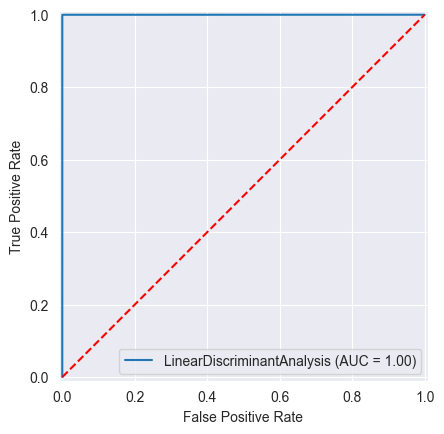

In [108]:
y_pred_train = model.predict(X_train)
# Classification Report - train
print('Classification Report - training set:\n',metrics.classification_report(y_train.ravel(), y_pred_train))

# Confusion Matrix - train
print('Confusion Matrix - training set:\n',metrics.confusion_matrix(y_train.ravel(), y_pred_train, normalize='all').round(2))

y_predproba_train = model.predict_proba(X_train)[:, -1]
# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_train.ravel(), y_predproba_train)
roc_auc = metrics.roc_auc_score(y_train.ravel(), y_predproba_train)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='LinearDiscriminantAnalysis')
display.plot()
plt.plot([0,1],[0,1],'r--')
plt.show()

Classification Report - test set:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     69587
         1.0       1.00      1.00      1.00     35589

    accuracy                           1.00    105176
   macro avg       1.00      1.00      1.00    105176
weighted avg       1.00      1.00      1.00    105176

Confusion Matrix - test set:
 [[0.66 0.  ]
 [0.   0.34]]


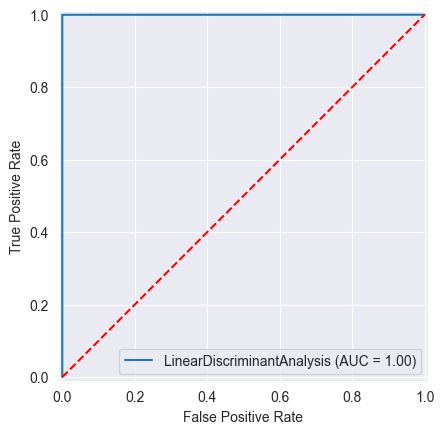

In [109]:
y_pred_test = model.predict(X_test)
# Classification Report - test
print('Classification Report - test set:\n',metrics.classification_report(y_test.ravel(), y_pred_test))

# Confusion Matrix - test
print('Confusion Matrix - test set:\n',metrics.confusion_matrix(y_test.ravel(), y_pred_test, normalize='all').round(2))

y_predproba_test = model.predict_proba(X_test)[:, -1]
# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test.ravel(), y_predproba_test)
roc_auc = metrics.roc_auc_score(y_test.ravel(), y_predproba_test)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='LinearDiscriminantAnalysis')
display.plot()
plt.plot([0,1],[0,1],'r--')
plt.show()

# Quark/Gluon discrimination

## Not normalizing

In [110]:
# separação de variáveis preditoras (features) e alvo (target)
X_g,y_g = EFPg, np.zeros((EFPg.shape[0], 1))
X_q,y_q = EFPq, np.ones((EFPq.shape[0], 1))

# particionamento (amostragem estratificada)
X_g_train, X_g_test, y_g_train, y_g_test = train_test_split(X_g, y_g, test_size=0.2, random_state=1)
X_q_train, X_q_test, y_q_train, y_q_test = train_test_split(X_q, y_q, test_size=0.2, random_state=1)

X_train, X_test, y_train, y_test = (
    np.concatenate((X_g_train, X_q_train), axis=0),
    np.concatenate((X_g_test, X_q_test), axis=0),
    np.concatenate((y_g_train, y_q_train), axis=0),
    np.concatenate((y_g_test, y_q_test), axis=0)
)

### LinearDiscriminantAnalysis

Intercept: 4.036241584698462


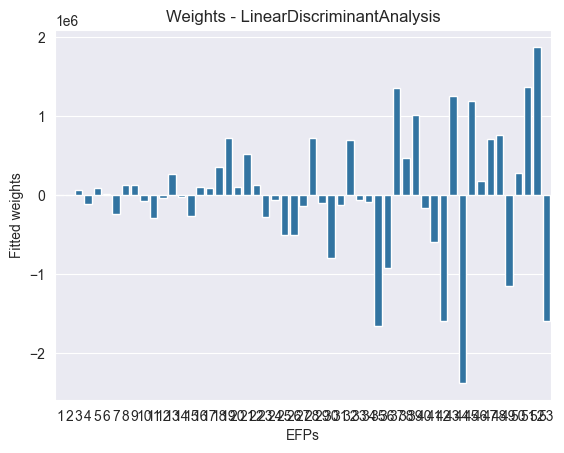

In [111]:
model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train.ravel())

# Intercept
print('Intercept:', model.intercept_[0])

# Weights
coef = model.coef_[0]
fig = sns.barplot (x=np.arange(1, len(coef)+1), y=coef)
plt.xlabel("EFPs")
plt.ylabel("Fitted weights")
plt.title("Weights - LinearDiscriminantAnalysis");

Classification Report - training set:
               precision    recall  f1-score   support

         0.0       0.73      0.71      0.72    141801
         1.0       0.71      0.72      0.71    136543

    accuracy                           0.72    278344
   macro avg       0.72      0.72      0.72    278344
weighted avg       0.72      0.72      0.72    278344

Confusion Matrix - training set:
 [[0.36 0.15]
 [0.14 0.35]]


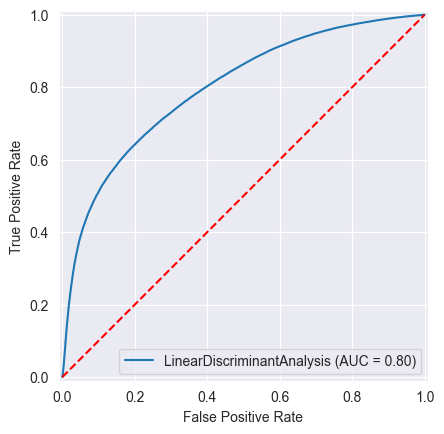

In [112]:
y_pred_train = model.predict(X_train)
# Classification Report - train
print('Classification Report - training set:\n',metrics.classification_report(y_train.ravel(), y_pred_train))

# Confusion Matrix - train
print('Confusion Matrix - training set:\n',metrics.confusion_matrix(y_train.ravel(), y_pred_train, normalize='all').round(2))

y_predproba_train = model.predict_proba(X_train)[:, -1]
# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_train.ravel(), y_predproba_train)
roc_auc = metrics.roc_auc_score(y_train.ravel(), y_predproba_train)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='LinearDiscriminantAnalysis')
display.plot()
plt.plot([0,1],[0,1],'r--')
plt.show()

Classification Report - test set:
               precision    recall  f1-score   support

         0.0       0.73      0.71      0.72     35451
         1.0       0.71      0.72      0.71     34136

    accuracy                           0.72     69587
   macro avg       0.72      0.72      0.72     69587
weighted avg       0.72      0.72      0.72     69587

Confusion Matrix - test set:
 [[0.36 0.15]
 [0.14 0.35]]


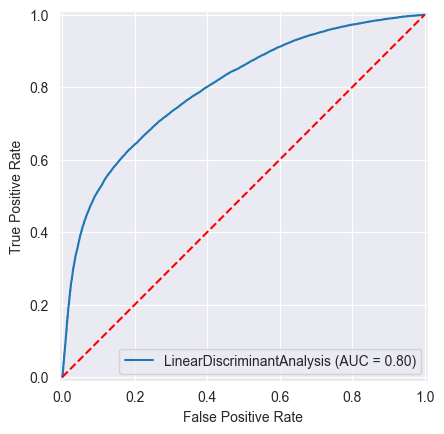

In [113]:
y_pred_test = model.predict(X_test)
# Classification Report - test
print('Classification Report - test set:\n',metrics.classification_report(y_test.ravel(), y_pred_test))

# Confusion Matrix - test
print('Confusion Matrix - test set:\n',metrics.confusion_matrix(y_test.ravel(), y_pred_test, normalize='all').round(2))

y_predproba_test = model.predict_proba(X_test)[:, -1]
# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test.ravel(), y_predproba_test)
roc_auc = metrics.roc_auc_score(y_test.ravel(), y_predproba_test)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='LinearDiscriminantAnalysis')
display.plot()
plt.plot([0,1],[0,1],'r--')
plt.show()

### QuadraticDiscriminantAnalysis

In [114]:
model = QuadraticDiscriminantAnalysis(tol=1.0e-6)
model.fit(X_train, y_train.ravel())

QuadraticDiscriminantAnalysis(tol=1e-06)

Classification Report - training set:
               precision    recall  f1-score   support

         0.0       0.81      0.25      0.38    141801
         1.0       0.55      0.94      0.69    136543

    accuracy                           0.59    278344
   macro avg       0.68      0.59      0.54    278344
weighted avg       0.68      0.59      0.53    278344

Confusion Matrix - training set:
 [[0.13 0.38]
 [0.03 0.46]]


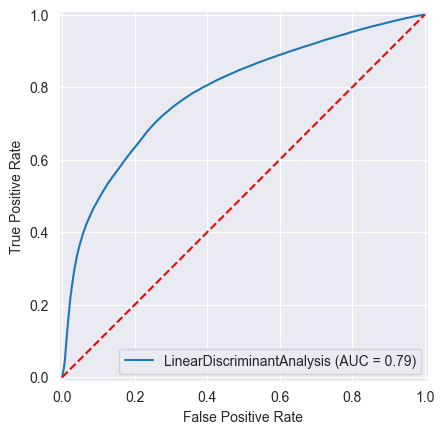

In [115]:
y_pred_train = model.predict(X_train)
# Classification Report - train
print('Classification Report - training set:\n',metrics.classification_report(y_train.ravel(), y_pred_train))

# Confusion Matrix - train
print('Confusion Matrix - training set:\n',metrics.confusion_matrix(y_train.ravel(), y_pred_train, normalize='all').round(2))

y_predproba_train = model.predict_proba(X_train)[:, -1]
# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_train.ravel(), y_predproba_train)
roc_auc = metrics.roc_auc_score(y_train.ravel(), y_predproba_train)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='LinearDiscriminantAnalysis')
display.plot()
plt.plot([0,1],[0,1],'r--')
plt.show()

C:\Users\bruno\OneDrive\IA na física\projeto2 - classificação de jatos\pythonProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bruno\OneDrive\IA na física\projeto2 - classificação de jatos\pythonProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bruno\OneDrive\IA na física\projeto2 - classificação de jatos\pythonProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

Classification Report - test set:
               precision    recall  f1-score   support

         0.0       0.51      1.00      0.68     35451
         1.0       0.00      0.00      0.00     34136

    accuracy                           0.51     69587
   macro avg       0.25      0.50      0.34     69587
weighted avg       0.26      0.51      0.34     69587

Confusion Matrix - test set:
 [[0.51 0.  ]
 [0.49 0.  ]]


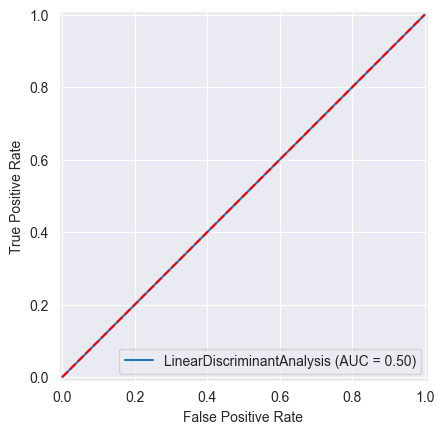

In [118]:
y_pred_test = model.predict(X_test)
# Classification Report - test
print('Classification Report - test set:\n',metrics.classification_report(y_test.ravel(), y_pred_test))

# Confusion Matrix - test
print('Confusion Matrix - test set:\n',metrics.confusion_matrix(y_test.ravel(), y_pred_test, normalize='all').round(2))

y_predproba_test = model.predict_proba(X_test)[:, -1]
# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test.ravel(), y_predproba_test)
roc_auc = metrics.roc_auc_score(y_test.ravel(), y_predproba_test)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='LinearDiscriminantAnalysis')
display.plot()
plt.plot([0,1],[0,1],'r--')
plt.show()

## Normalizing

In [119]:
# separação de variáveis preditoras (features) e alvo (target)
X_g,y_g = rescaledEFPg, np.zeros((rescaledEFPg.shape[0], 1))
X_q,y_q = rescaledEFPq, np.ones((rescaledEFPq.shape[0], 1))

# particionamento (amostragem estratificada)
X_g_train, X_g_test, y_g_train, y_g_test = train_test_split(X_g, y_g, test_size=0.2, random_state=1)
X_q_train, X_q_test, y_q_train, y_q_test = train_test_split(X_q, y_q, test_size=0.2, random_state=1)

X_train, X_test, y_train, y_test = (
    np.concatenate((X_g_train, X_q_train), axis=0),
    np.concatenate((X_g_test, X_q_test), axis=0),
    np.concatenate((y_g_train, y_q_train), axis=0),
    np.concatenate((y_g_test, y_q_test), axis=0)
)

### LinearDiscriminantAnalysis

Intercept: -0.03779763642067813


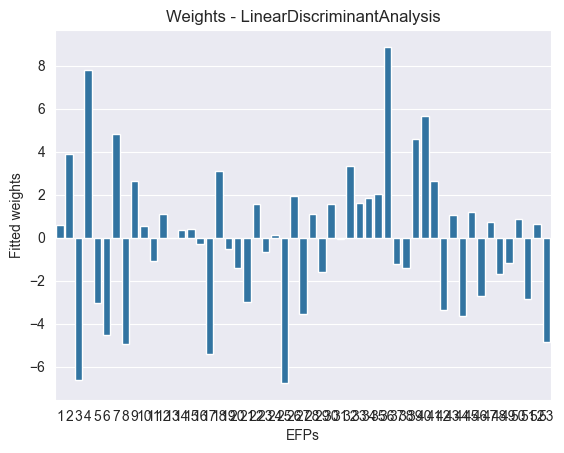

In [120]:
model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train.ravel())

# Intercept
print('Intercept:', model.intercept_[0])

# Weights
coef = model.coef_[0]
fig = sns.barplot (x=np.arange(1, len(coef)+1), y=coef)
plt.xlabel("EFPs")
plt.ylabel("Fitted weights")
plt.title("Weights - LinearDiscriminantAnalysis");

Classification Report - training set:
               precision    recall  f1-score   support

         0.0       0.51      1.00      0.67    141801
         1.0       0.44      0.00      0.01    136543

    accuracy                           0.51    278344
   macro avg       0.47      0.50      0.34    278344
weighted avg       0.47      0.51      0.35    278344

Confusion Matrix - training set:
 [[0.51 0.  ]
 [0.49 0.  ]]


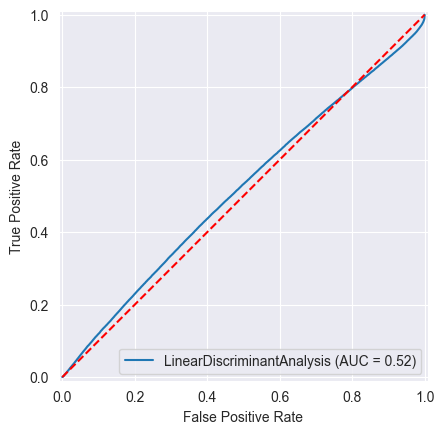

In [121]:
y_pred_train = model.predict(X_train)
# Classification Report - train
print('Classification Report - training set:\n',metrics.classification_report(y_train.ravel(), y_pred_train))

# Confusion Matrix - train
print('Confusion Matrix - training set:\n',metrics.confusion_matrix(y_train.ravel(), y_pred_train, normalize='all').round(2))

y_predproba_train = model.predict_proba(X_train)[:, -1]
# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_train.ravel(), y_predproba_train)
roc_auc = metrics.roc_auc_score(y_train.ravel(), y_predproba_train)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='LinearDiscriminantAnalysis')
display.plot()
plt.plot([0,1],[0,1],'r--')
plt.show()

Classification Report - test set:
               precision    recall  f1-score   support

         0.0       0.51      1.00      0.67     35451
         1.0       0.40      0.00      0.01     34136

    accuracy                           0.51     69587
   macro avg       0.45      0.50      0.34     69587
weighted avg       0.46      0.51      0.35     69587

Confusion Matrix - test set:
 [[0.51 0.  ]
 [0.49 0.  ]]


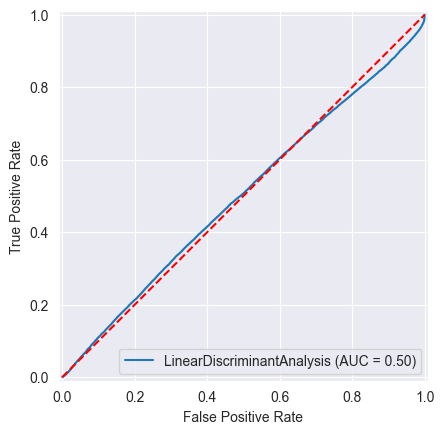

In [122]:
y_pred_test = model.predict(X_test)
# Classification Report - test
print('Classification Report - test set:\n',metrics.classification_report(y_test.ravel(), y_pred_test))

# Confusion Matrix - test
print('Confusion Matrix - test set:\n',metrics.confusion_matrix(y_test.ravel(), y_pred_test, normalize='all').round(2))

y_predproba_test = model.predict_proba(X_test)[:, -1]
# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test.ravel(), y_predproba_test)
roc_auc = metrics.roc_auc_score(y_test.ravel(), y_predproba_test)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='LinearDiscriminantAnalysis')
display.plot()
plt.plot([0,1],[0,1],'r--')
plt.show()

### QuadraticDiscriminantAnalysis

In [123]:
model = QuadraticDiscriminantAnalysis(tol=1.0e-6)
model.fit(X_train, y_train.ravel())

QuadraticDiscriminantAnalysis(tol=1e-06)

Classification Report - training set:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    141801
         1.0       1.00      1.00      1.00    136543

    accuracy                           1.00    278344
   macro avg       1.00      1.00      1.00    278344
weighted avg       1.00      1.00      1.00    278344

Confusion Matrix - training set:
 [[0.51 0.  ]
 [0.   0.49]]


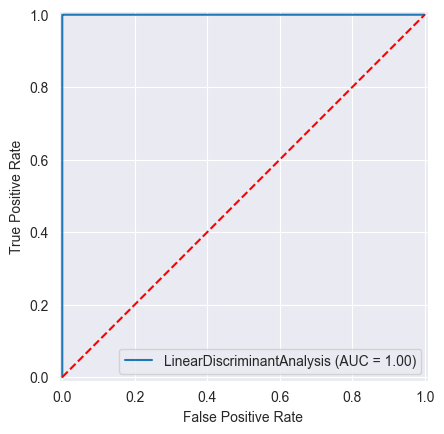

In [124]:
y_pred_train = model.predict(X_train)
# Classification Report - train
print('Classification Report - training set:\n',metrics.classification_report(y_train.ravel(), y_pred_train))

# Confusion Matrix - train
print('Confusion Matrix - training set:\n',metrics.confusion_matrix(y_train.ravel(), y_pred_train, normalize='all').round(2))

y_predproba_train = model.predict_proba(X_train)[:, -1]
# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_train.ravel(), y_predproba_train)
roc_auc = metrics.roc_auc_score(y_train.ravel(), y_predproba_train)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='LinearDiscriminantAnalysis')
display.plot()
plt.plot([0,1],[0,1],'r--')
plt.show()

Classification Report - test set:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     35451
         1.0       1.00      1.00      1.00     34136

    accuracy                           1.00     69587
   macro avg       1.00      1.00      1.00     69587
weighted avg       1.00      1.00      1.00     69587

Confusion Matrix - test set:
 [[0.51 0.  ]
 [0.   0.49]]


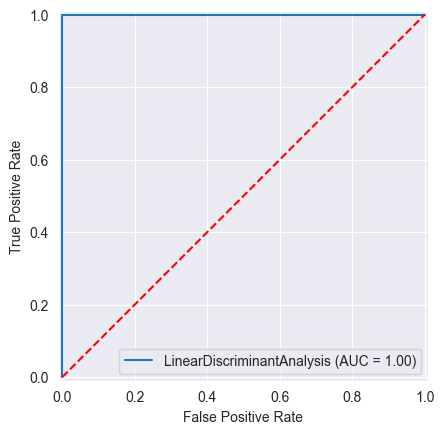

In [125]:
y_pred_test = model.predict(X_test)
# Classification Report - test
print('Classification Report - test set:\n',metrics.classification_report(y_test.ravel(), y_pred_test))

# Confusion Matrix - test
print('Confusion Matrix - test set:\n',metrics.confusion_matrix(y_test.ravel(), y_pred_test, normalize='all').round(2))

y_predproba_test = model.predict_proba(X_test)[:, -1]
# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test.ravel(), y_predproba_test)
roc_auc = metrics.roc_auc_score(y_test.ravel(), y_predproba_test)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='LinearDiscriminantAnalysis')
display.plot()
plt.plot([0,1],[0,1],'r--')
plt.show()